In [2]:
from code2 import *
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import numpy as np
# import vgg16
import cv2

images = []
for i in range(1,99):
    s="../test_data/" + str(i)+'.jpg'
    images.append(plt.imread(s))

inputImage=[]
outputImage=[]
for image in images:
    imgReal=image[:,:int(image.shape[1]/2),:]
    imgFin=image[:,-int(image.shape[1]/2):,:]
    i=cv2.resize(imgReal,(256,256))
    j=cv2.resize(imgFin,(256,256))
    inputImage.append(j)
    outputImage.append(i)

Ximgs = np.array(inputImage)
Yimgs = np.array(outputImage)




In [3]:

G=Generator()
X=tf.placeholder(tf.float32,shape=[None,256,256,3])
Y=tf.placeholder(tf.float32,shape=[None,256,256,3])
# X=tf.reshape(Ximgs,[-1,256,256,3])
conv1Out=G.addConvLayer(X,3,64)
conv2Out=G.addConvLayer(conv1Out,64,64)
conv3Out=G.addConvLayer(conv2Out,64,64)
conv4Out=G.addConvLayer(conv3Out,64,64)
conv5Out=G.addConvLayer(conv4Out,64,32)
conv6Out=G.addConvLayer(conv5Out,32,1)
deconv1Out=G.addDeConvLayer(conv6Out,1,32)
deconv2Out=G.addDeConvLayer(deconv1Out,32,64) + conv4Out
deconv3Out=G.addDeConvLayer(deconv2Out,64,64)
deconv4Out=G.addDeConvLayer(deconv3Out,64,64) + conv2Out
deconv5Out=G.addDeConvLayer(deconv4Out,64,64)
GX=G.addDeConvLayer(deconv5Out,64,3) + X

##########################################################


#This defines the discriminator, with input as Y(original image without rain)

D=Generator()
Dconv1Out=D.addConvLayer(Y,3,48,strideX=2, strideY=2,filterSize=4,BN=False)
Dconv2Out=D.addConvLayer(Dconv1Out,48,96,strideX=2, strideY=2,filterSize=4)
Dconv3Out=D.addConvLayer(Dconv2Out,96,192,strideX=2, strideY=2,filterSize=4)
Dconv4Out=D.addConvLayer(Dconv3Out,192,384,strideX=1, strideY=1,filterSize=4)
Dconv5Out=D.addConvLayer(Dconv4Out,384,1,strideX=1, strideY=1,filterSize=4,BN=False,PRelu=False)
DY = D.addDeepNet(Dconv5Out)

Le = tf.reduce_mean(tf.squared_difference(GX,Y))
La_Y = -tf.reduce_mean(tf.log(DY))
DX_ = D.forward(GX)
La_X_ = -tf.reduce_mean(tf.log(1-DX_))
La = La_Y + La_X_

# for i in range(100):



#Le = tf.reduce_mean(tf.squared_difference(GX,Y))
#La = 

#finding D of original image
# D.setInput(Y)
# Dori = tf.nn.sigmoid(D.forward(Y))
# Lp = (tf.reduce_mean(tf.squared_difference(DY,Dori)))
L = 0.0066 * La + Le 

solver =  tf.train.AdamOptimizer().minimize(L)
saver=tf.train.Saver()

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver.restore(sess, "model2.ckpt")


INFO:tensorflow:Restoring parameters from model2.ckpt


In [4]:
img=sess.run(GX,feed_dict={X:Ximgs[70:77]})
plt.imshow((img[1]).astype(np.uint8))

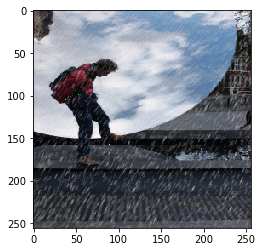

In [9]:
plt.imshow((img[1]).astype(np.uint8))
plt.show()

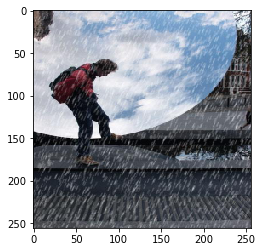

In [8]:
plt.imshow(Ximgs[71])
plt.show()

In [15]:
def psnr(originalImg,predictedImg):
    mse = np.mean((originalImg - predictedImg)**2)
    return 20*np.log10(255)-10*np.log10(mse)

In [16]:
a=0

for i in range(0,98,7):
    genImg = sess.run(GX,feed_dict={X:Ximgs[i:i+7]})
    a+=np.mean(psnr(Yimgs[i:i+7],genImg))
    
print(a)

306.029171798


In [17]:
a/14

21.859226556971432

In [20]:
psnr(Yimgs[0],img[0])

18.67870619275503

In [37]:
predImgs=[]
for i in range(0,98,7):
    genImg = sess.run(GX,feed_dict={X:Ximgs[i:i+7]})
    predImgs.append(genImg)


In [38]:
pred = np.concatenate(predImgs)

In [39]:
pred.shape

(98, 256, 256, 3)

In [41]:
from sklearn.metrics import accuracy_score
acc=accuracy_score(Yimgs, pred)

ValueError: unknown is not supported